In [13]:
%matplotlib notebook
import math
import os
import numpy as np
import sympy as sym
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
from IPython.display import display, Math, Markdown
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)
path = "C:/Users/Thomas/Laboratorio_Intermedio/Franck-Hertz/Data/"
path_ = "C:/Users/Thomas/Laboratorio_Intermedio/Franck-Hertz/Images/"
plt.rcParams["savefig.directory"] = path_

In [14]:
def ChangeType(array):
    array_ = array.copy()
    for i in range(0, len(array)):
        array_[i] = float(array[i].replace(",", "."))
    return array_

def DataAnalysis(directory, index):
    """
    Esta función tiene como trabajo el tomar los datos de cada carpeta y someterlos al análisis estadístico
    requerido para las mediciones del experimento de Franck-Hertz. Cada dato tendrá un error asociado a la desviación
    estándar asociada a los puntos de ese mismo valor de voltaje.
    """
    
    Base = []
    for i in range(0, len(index)):
        base = pd.read_csv(path + directory + index[i], sep = "	")
        Base.append(base)
        
    BaseCurrents = []
    BaseVoltages = None
    limit = None
    
    for i in range(0, len(index)):
        # Solo se almacena un conjunto de voltajes (son los mismos para todas las mediciones).
        if i == 0:
            voltage = Base[i]["U1/V"].to_numpy()
            voltage = ChangeType(voltage)
            voltage = voltage[voltage <= 60]
            BaseVoltages = voltage
            limit = len(voltage)
            
        # Se toman los valores de corriente asociados al límite establecido. 
        # (Sólo los asociados a voltajes menores o iguales a 50 V)
        current = Base[i]["IA/nA"].to_numpy()
        current = ChangeType(current)[0:limit]
        BaseCurrents.append(current)
    
    # A partir de esto se trabaja con el promedio de los datos en cada punto, para luego determinar 
    MeanBase = np.array([])
    ErrorBase = np.array([])

    for i in range(0, len(BaseVoltages)):
        simpleSet = np.array([])
        for j in range(0, len(index)):
            simpleSet = np.append(simpleSet, BaseCurrents[j][i])
            
        value = np.mean(simpleSet)
        error = np.std(simpleSet)

        MeanBase = np.append(MeanBase, value)
        ErrorBase = np.append(ErrorBase, error)
        
    return (BaseVoltages, MeanBase, ErrorBase)

def GaussianMinima(voltage, current):
    # Suavizar la curva usando un filtro gaussiano
    smooth_current = gaussian_filter1d(current, sigma=5)

    # Encontrar los mínimos locales en la curva suavizada
    min_smooth_indexes, _ = find_peaks(-smooth_current)  # Invertir la corriente suavizada para encontrar mínimos

    # Crear un DataFrame con los resultados de los mínimos locales
    min_smooth_voltages = voltage[min_smooth_indexes]
    min_smooth_currents = smooth_current[min_smooth_indexes]

    min_smooth_df = pd.DataFrame({'Voltaje U1': min_smooth_voltages, 'Corriente IA Suavizada': min_smooth_currents})

    return min_smooth_df, smooth_current

def Separation(Set):
    x, y = Set
    delta_y = np.array([])
    for i in range(1, len(x)):
        delta_y = np.append(delta_y, x[i] - x[i - 1])
    min_number = np.linspace(1, len(delta_y), len(delta_y))
    return min_number, delta_y

def Linear(x, a, b):
    return a*x + b

def Computation_Error(expression, symbols, parameters):
    error_2 = 0.
    ward = int((len(symbols)/2))
    func_value = sym.lambdify(symbols[0:ward], expression)
    value = func_value(*parameters[0:ward])

    for i in range(0, len(symbols[0:ward])):
        unc_ward = ward + i
        error_2 += sym.diff(expression, symbols[i])**2 * (symbols[unc_ward])**2

    func_error_2 = sym.lambdify(symbols, error_2)
    value_error_2 = func_error_2(*parameters)
    
    error = np.sqrt(value_error_2)
    
    if error == 0:
        return value, error  # Evita la división por cero
    
    significant = -int(math.floor(math.log10(error)))
    
    # Redondear el valor principal y la incertidumbre a esas cifras significativas
    value_ = round(value, significant)
    error_ = round(error, significant)
    
    return value_, error_

def LinearRegression(x, y):
    func_var, func_unc = np.polyfit(x, y, 1, cov = True)
    func_unc = np.sqrt(np.diag(func_unc))

    x_ = np.linspace(min(x), max(x), 100)
    y_ = Linear(x_, *func_var)
    
    Residuals = y - Linear(x, *func_var)
    standarDev = np.std(Residuals)
    NormResiduals = Residuals/standarDev
    
    a, b, unca, uncb = sym.symbols("a, b, sigma_a, sigma_b", real = True)
    sym_ = a, b, unca, uncb
    exp = a*0.5 + b
    
    param = (func_var[0], func_var[1], func_unc[0], func_unc[1])
    Ea, Ea_unc = Computation_Error(exp, sym_, param)
    Ea_ = (Ea, Ea_unc)
    
    a_, b_, unca_, uncb_ = sym.symbols("a_, b_, sigma_a_, sigma_b_", real = True)
    sym__ = a_, b_, unca_, uncb_
    exp_ = 12/(2*a_) * b_
    
    param_ = (Ea, func_var[0], Ea_unc, func_unc[0])
    l , l_unc = Computation_Error(exp_, sym__, param_)
    l_ = (l, l_unc)
    
    return x_, y_, NormResiduals, Ea_, l_

> ## Bitácora - Experimento de Franck-Hertz

**Hecho por:** Simón Felipe Jimenez Botero & Thomas Andrade Hernández.

---

En el presente documento se encuentran desglozados los resultados de las mediciones asociadas al montaje experimental de Franck-Hertz. A lo largo de este código se podrán observar los resultados de cada medición, sumado a una breve explicación previa acerca de aquello que estamos haciendo, cómo lo estamos haciendo y alguna que otra cosa a tener presente para su replicación.

---

># Actividad #1: Análisis del comportamiento de los datos.

En esta parte inicial tomamos múltiples mediciones para un mismo valor de temperatura ($180^{\circ}$). Partiendo del comportamiento de las gráficas obtenidas, se decició tomar las cinco mediciones realizadas y realizar un estudio estadístico que consiste en que, para un mismo valor de voltaje, tomar los distintos valores de corriente detectados y, posteriormente, realizar un promedio y una desviación estándar de los datos para así determinar el error.

In [15]:
index = ["I", "II", "III", "IV", "V"]
directory = "Base/Base "

In [16]:
BaseVoltages, MeanBase, ErrorBase = DataAnalysis(directory, index)

<IPython.core.display.Javascript object>


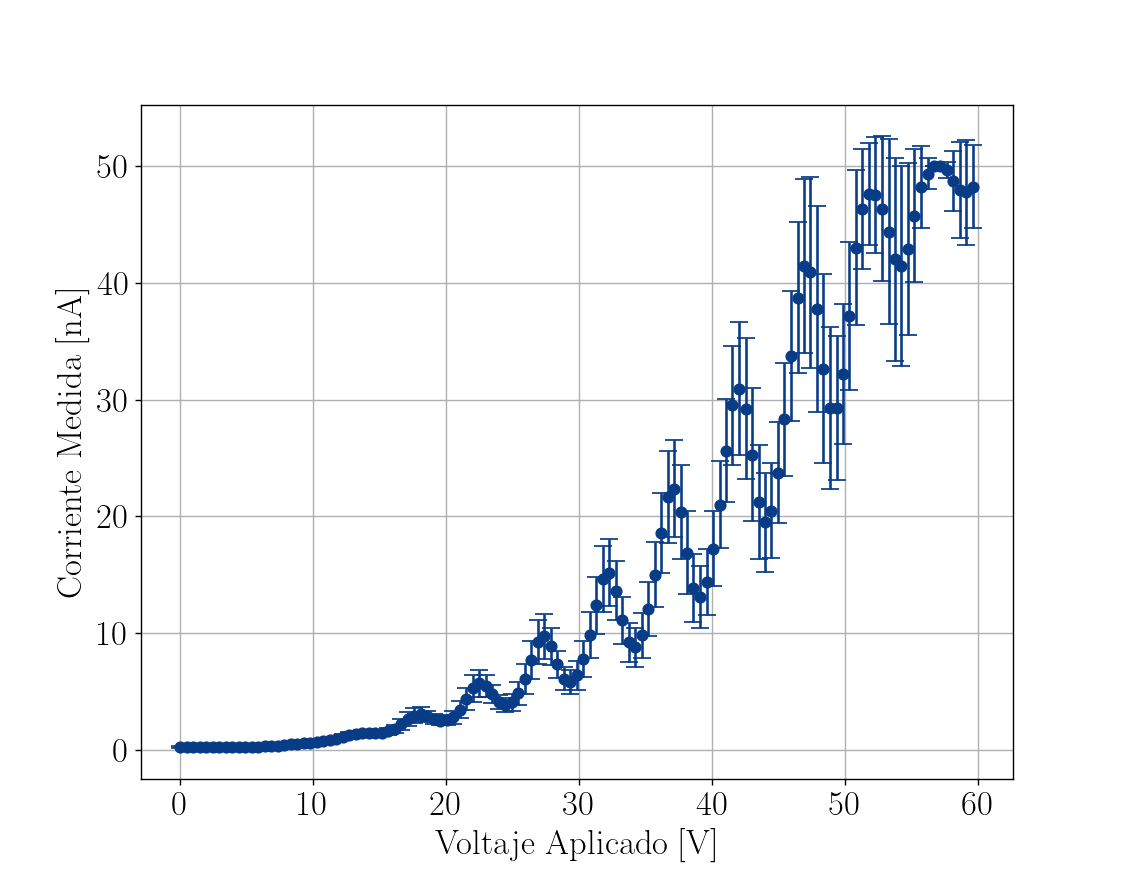

Text(0.5, 0, 'Voltaje Aplicado [V]')

In [17]:
N = 20
plt.figure(figsize = (9, 7))
plt.errorbar(BaseVoltages[::N], MeanBase[::N], yerr = ErrorBase[::N], color = "#083c87", capsize = 5, fmt = "o")
plt.grid(True)
plt.ylabel("Corriente Medida [nA]")
plt.xlabel("Voltaje Aplicado [V]")
# plt.savefig("Statistics.pdf")

Como se logra apreciar, las mediciones coinciden mucho para valores de voltaje por debajo de los $20$ V, mientras que, al elevar este valor, la dispersión de los datos se hace mucho más evidente. Por este motivo, para las actividades posteriores se decidió tomar varias mediciones para un mismo valor de temperatura para así observar el comportamiento "real" de los datos.

># Actividad #2: Comportamiento asociado al cambio térmico:

En la presente sesión se mostrará los resultados obtenidos de las tendencias para determinados valores de temperatura. Cabe aclarar que, debido al poco control por sobre la temperatura que pudimos tener, las oscilaciones térmicas en las mediciones fueron considerablemente altas. Se intentó minimizarlas pero es necesario reconocer que, para cada valor de temperatura hay asociado un error aproximado de $2^{\circ}$ por izquierda y derecha.

In [18]:
Temperatures = ["Activity I/Heat 185-180/", "Activity I/Heat 190-185/", "Activity I/Heat 195-190/", "Activity I/Heat 200-195/", "Activity I/Heat 206-201/"]
TempNames = ["185°-180°", "190°-185°", "195°-190°", "200°-195°", "206°-201°"]
TempIndexes = [["I", "II", "III"], ["I", "II", "III", "IV"], ["I", "II", "III", "IV"], ["I", "II", "III", "IV"], ["I", "II", "III", "IV"]]

In [19]:
TermicData = []
TermicCurrents = []
TermicMinimas = []

for i in range(0, len(Temperatures)):
    Voltages, Mean, Error = DataAnalysis(Temperatures[i], TempIndexes[i])
    TermicData.append([Voltages, Mean, Error])
    
    TermicTable, TermicCurrent = GaussianMinima(Voltages, Mean)
    TermicPair = (TermicTable['Voltaje U1'], TermicTable['Corriente IA Suavizada'])
    
    TermicMinimas.append(TermicPair)
    TermicCurrents.append(TermicCurrent)

<IPython.core.display.Javascript object>


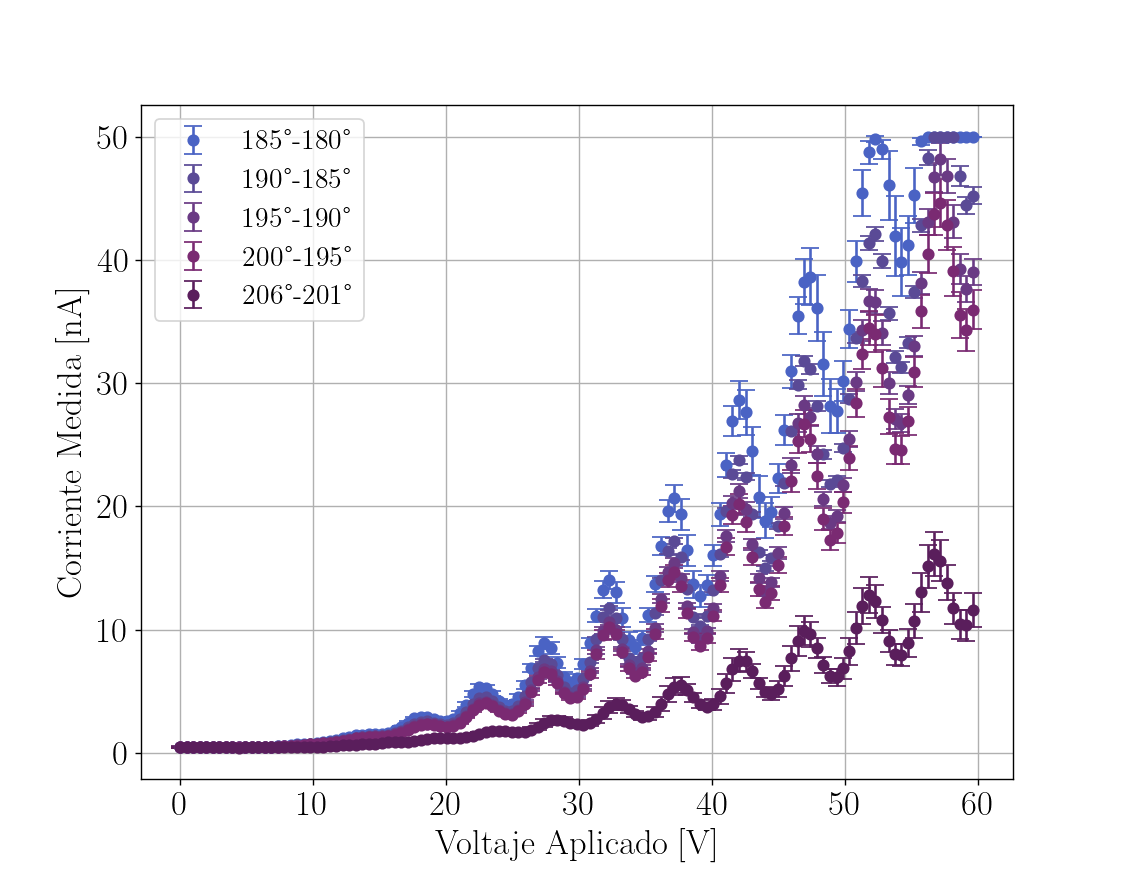

In [20]:
plt.figure(figsize = (9, 7))
Colors = ["#4A63C4", "#5A4A96", "#6A3A84", "#7A2A72", "#5A1E5C"]

N = 20
for i in range(0, len(TermicData)):
    plt.errorbar(TermicData[i][0][::N], TermicData[i][1][::N], yerr = TermicData[i][2][::N], color = Colors[i], label = TempNames[i], capsize = 5, fmt = "o")

plt.ylabel("Corriente Medida [nA]")
plt.xlabel("Voltaje Aplicado [V]")   
plt.legend(prop={'size': 16})
plt.grid(True)
# plt.savefig("TempData.pdf")

<IPython.core.display.Javascript object>


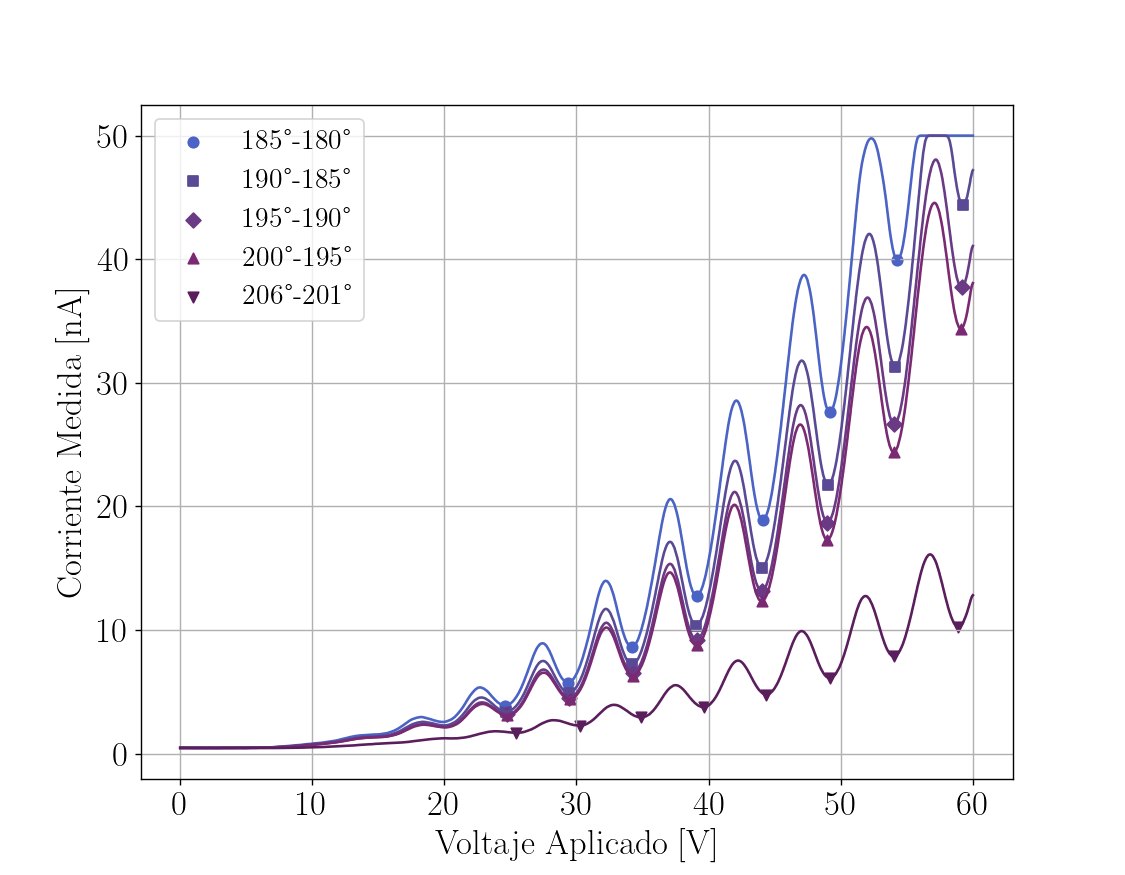

In [21]:
plt.figure(figsize = (9, 7))
Markers = ["o", "s", "D", "^", "v", "p"]
Terms = []

N = 1
for i in range(0, len(TermicData)):
    Term_x = np.array([])
    Term_y = np.array([])
    
    plt.plot(TermicData[i][0][::N], TermicCurrents[i][::N], color = Colors[i])
    
    for j in range(0, len(TermicMinimas[i][0])):
        if TermicMinimas[i][0][j] > 21:
            if j == len(TermicMinimas[i][0]) - 1:
                plt.scatter(TermicMinimas[i][0][j], TermicMinimas[i][1][j], marker = Markers[i], color = Colors[i], label = TempNames[i])
            else:
                plt.scatter(TermicMinimas[i][0][j], TermicMinimas[i][1][j], marker = Markers[i], color = Colors[i])
                
            Term_x = np.append(Term_x, TermicMinimas[i][0][j]) 
            Term_y = np.append(Term_y, TermicMinimas[i][1][j])
    
    Terms.append({TempNames[i]:(Term_x, Term_y)})
    
plt.ylabel("Corriente Medida [nA]")
plt.xlabel("Voltaje Aplicado [V]")   
plt.legend(prop={'size': 16})
plt.grid(True)
# plt.savefig("TempReg.pdf")

Se logra apreciar que, a mayor temperatura, menor es la corriente medida. La explicación a este fenómeno aún no la tenemos bien definida, por lo que se reservará el comentario para el informe.

<IPython.core.display.Javascript object>


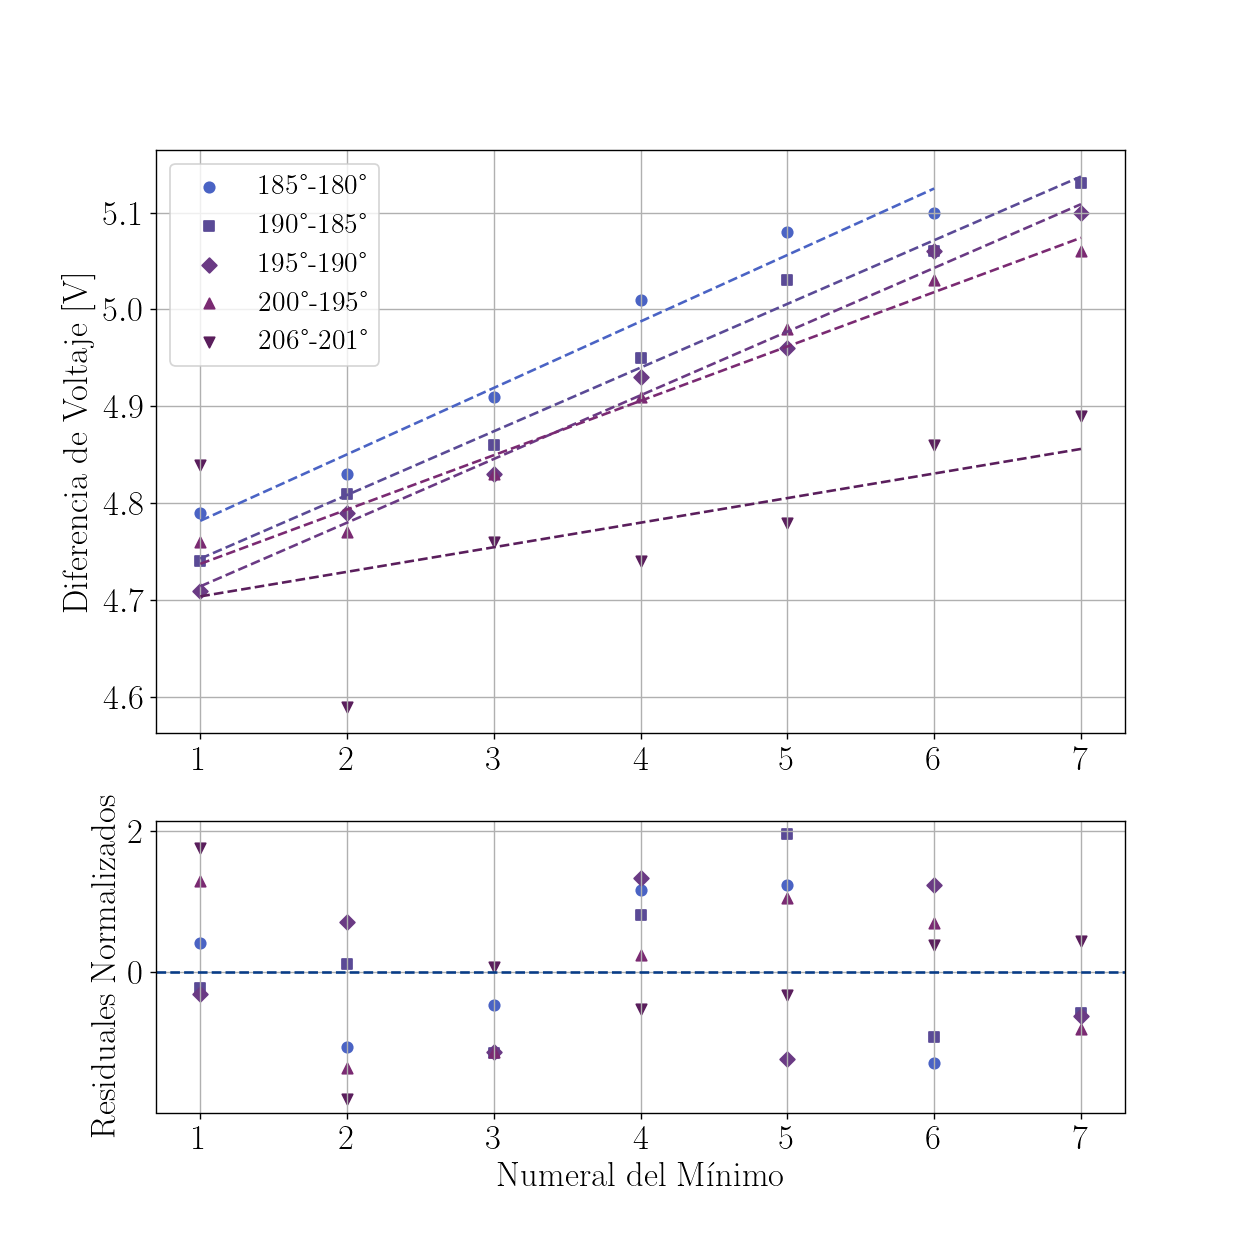

(4.75, 0.02) (0.087, 0.007) 4.0000000000000036
(4.71, 0.01) (0.084, 0.004) 4.0000000000000036
(4.68, 0.01) (0.084, 0.004) 0.9999999999999787
(4.71, 0.02) (0.071, 0.005) 2.0000000000000018
(4.69, 0.08) (0.03, 0.02) 0.2500000000000058


In [22]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
Markers = ["o", "s", "D", "^", "v", "p"]

for i in range(0, len(Terms)):
    TermSet = Terms[i][TempNames[i]]
    Term_Num, Term_Delta = Separation(TermSet)
    TermX_, TermY_, TermRes_, TermEa, TempL = LinearRegression(Term_Num, Term_Delta)
    axis[0].scatter(Term_Num, Term_Delta, marker = Markers[i], color = Colors[i], label = TempNames[i])
    axis[0].plot(TermX_, TermY_, color = Colors[i], linestyle = "--")
    axis[1].scatter(Term_Num, TermRes_, marker = Markers[i], color = Colors[i])
    print(TermEa, TempL, np.abs(4.67 - TermEa[0])/TermEa[1])

axis[1].set_xlabel("Numeral del Mínimo")
axis[0].set_ylabel("Diferencia de Voltaje [V]")   
axis[1].set_ylabel("Residuales Normalizados") 
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[0].legend(prop = {'size': 16})
axis[0].grid(True)
axis[1].grid(True)
# plt.savefig("TempLine.pdf")

># Actividad #3: Comportamiento asociado al cambio de UA:

En esta sesión se mostrará los resultados obtenidos de las tendencias para diferentes valores de $U_A$.

In [23]:
UAs = ["Activity II (200-205)/UA 1.0/", "Activity II (200-205)/UA 1.3/", "Activity II (200-205)/UA 1.5/", "Activity II (200-205)/UA 1.8/", "Activity II (200-205)/UA 2.0/"]
UANames = ["1.0 V", "1.3 V", "1.5 V", "1.8 V", "2.0 V"]
UAIndexes = [["I", "II"], ["II", "III"], ["I", "II", "III"], ["I", "II", "III"], ["I", "II", "III"]]

In [24]:
UAData = []
UACurrents = []
UAMinimas = []

for i in range(0, len(UAs)):
    Voltages, Mean, Error = DataAnalysis(UAs[i], UAIndexes[i])
    UAData.append([Voltages, Mean, Error])
        
    UATable, UACurrent = GaussianMinima(Voltages, Mean)
    UAPair = (UATable['Voltaje U1'], UATable['Corriente IA Suavizada'])
    
    UAMinimas.append(UAPair)
    UACurrents.append(UACurrent)

<IPython.core.display.Javascript object>


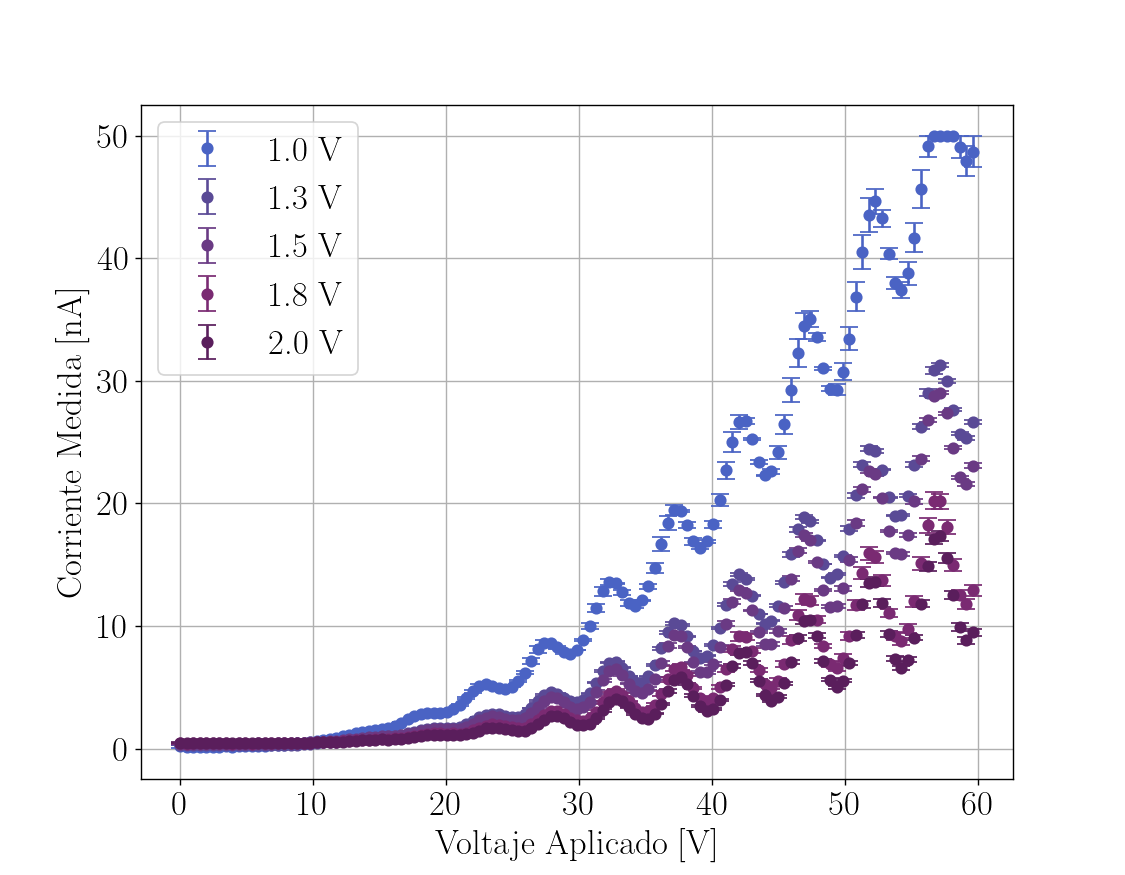

In [25]:
plt.figure(figsize = (9, 7))

N = 20
for i in range(0, len(UAData)):
    plt.errorbar(UAData[i][0][::N], UAData[i][1][::N], yerr = UAData[i][2][::N], color = Colors[i], label = UANames[i], capsize = 5, fmt = "o")

plt.ylabel("Corriente Medida [nA]")
plt.xlabel("Voltaje Aplicado [V]")   
plt.legend()
plt.grid(True)
# plt.savefig("UAData.pdf")

<IPython.core.display.Javascript object>


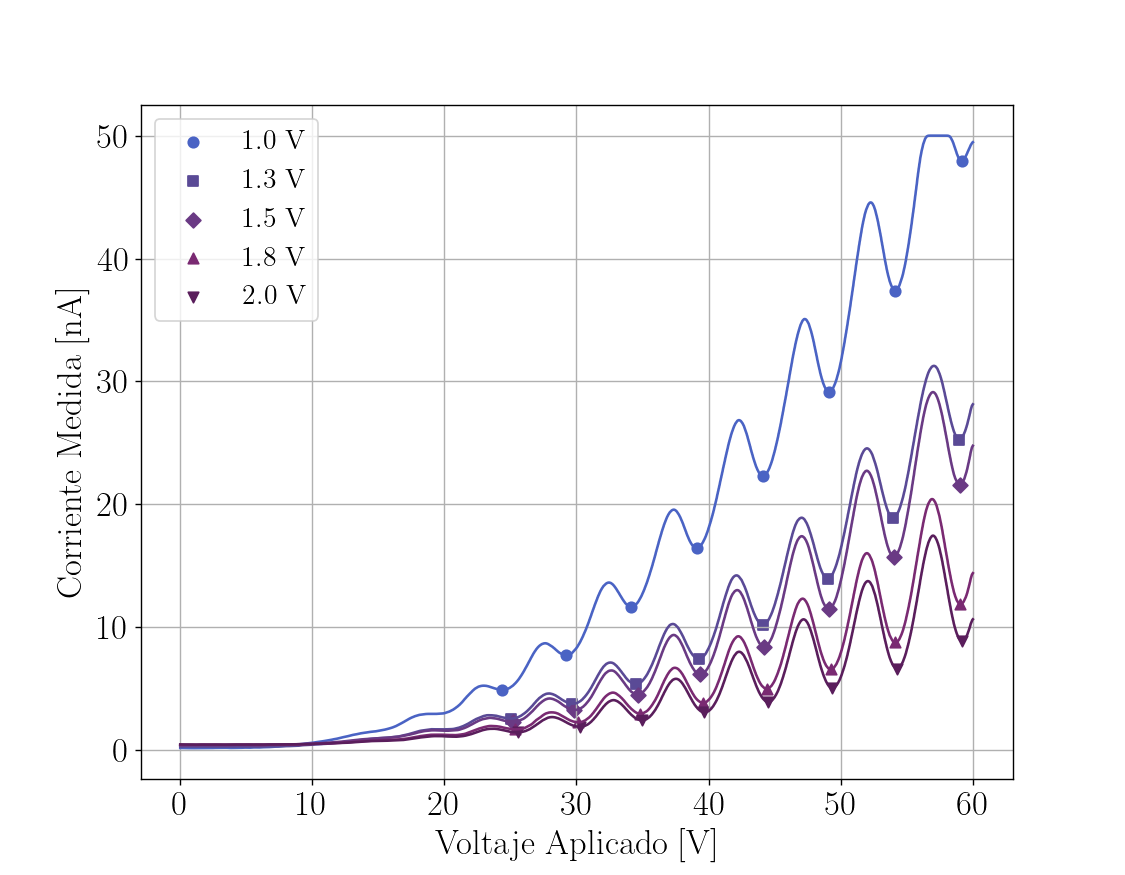

In [26]:
plt.figure(figsize = (9, 7))
Markers = ["o", "s", "D", "^", "v", "p"]
UAs = []

N = 1
for i in range(0, len(UAData)):
    UA_x = np.array([])
    UA_y = np.array([])
    
    plt.plot(UAData[i][0][::N], UACurrents[i][::N], color = Colors[i])
    
    for j in range(0, len(UAMinimas[i][0])):
        if UAMinimas[i][0][j] > 21:
            if j == len(UAMinimas[i][0]) - 1:
                plt.scatter(UAMinimas[i][0][j], UAMinimas[i][1][j], marker = Markers[i], color = Colors[i], label = UANames[i])
            else:
                plt.scatter(UAMinimas[i][0][j], UAMinimas[i][1][j], marker = Markers[i], color = Colors[i])
                
            UA_x = np.append(UA_x, UAMinimas[i][0][j]) 
            UA_y = np.append(UA_y, UAMinimas[i][1][j])
    
    UAs.append({UANames[i]:(UA_x, UA_y)})
    
plt.ylabel("Corriente Medida [nA]")
plt.xlabel("Voltaje Aplicado [V]")   
plt.legend(prop={'size': 16})
plt.grid(True)
# plt.savefig("UAReg.pdf")

Se logra apreciar que, a mayores valores de $U_{A}$, menor es la corriente medida. La explicación de este comportamiento se deja para el informe.

<IPython.core.display.Javascript object>


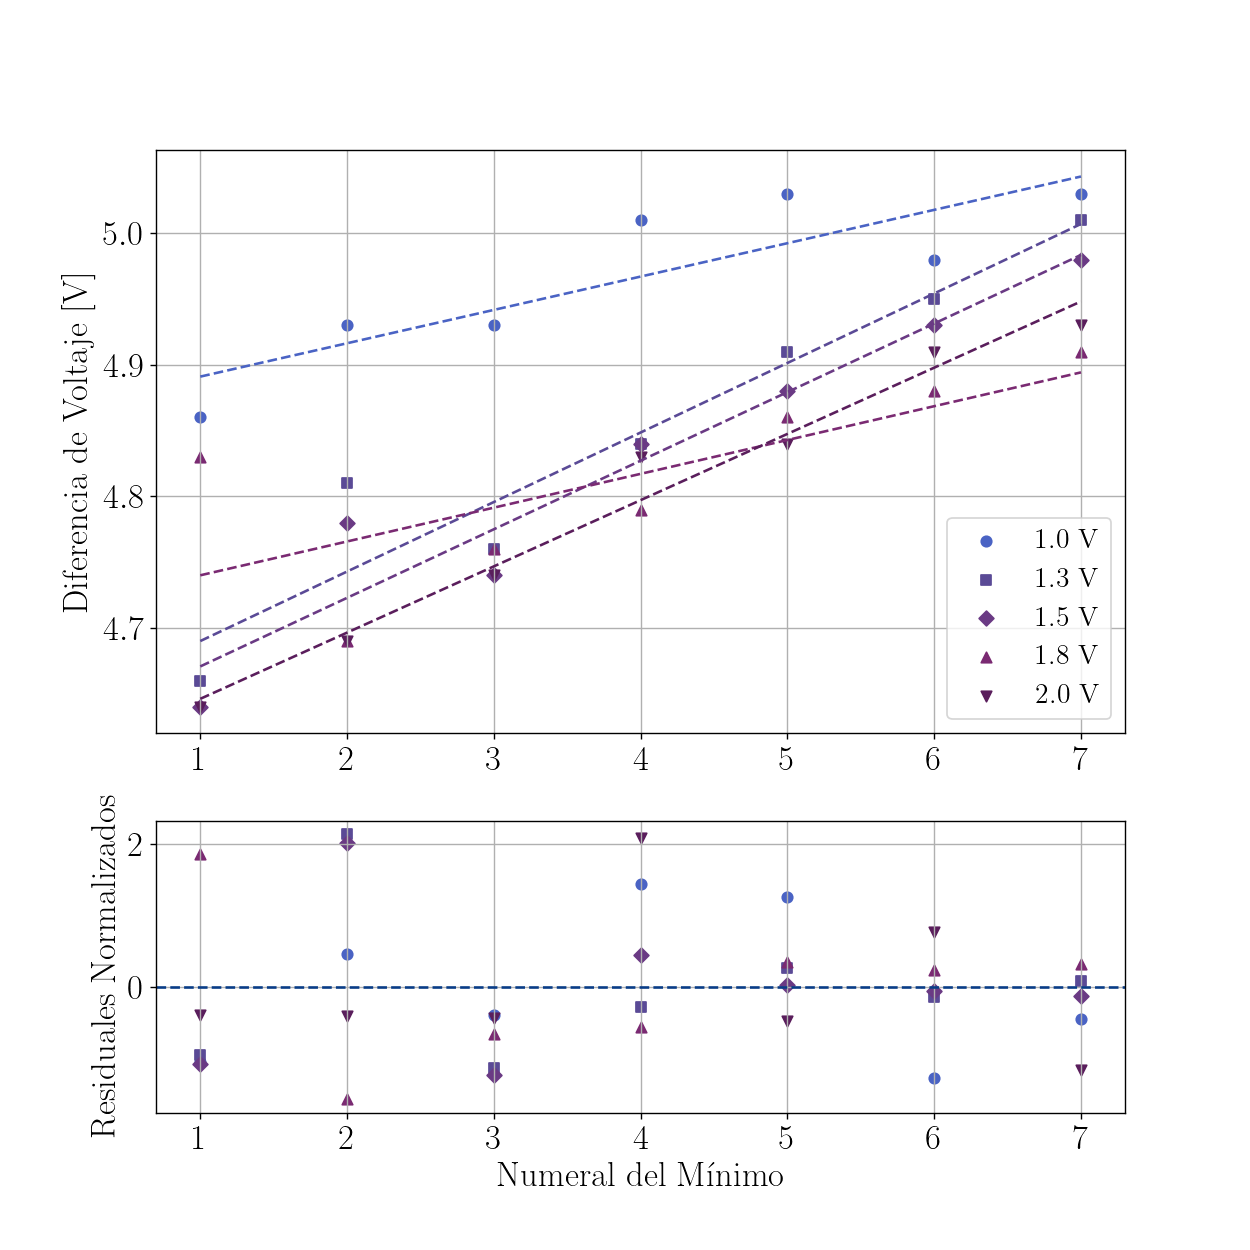

(4.88, 0.03) (0.031, 0.008) 6.999999999999999
(4.66, 0.03) (0.068, 0.009) 0.33333333333332626
(4.64, 0.03) (0.067, 0.008) 1.0000000000000084
(4.73, 0.05) (0.03, 0.01) 1.20000000000001
(4.62, 0.02) (0.065, 0.005) 2.499999999999991


In [27]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
Markers = ["o", "s", "D", "^", "v", "p"]

for i in range(0, len(UAs)):
    UASet = UAs[i][UANames[i]]
    UA_Num, UA_Delta = Separation(UASet)
    UAX_, UAY_, UARes_, UAEa, UAL = LinearRegression(UA_Num, UA_Delta)
    axis[0].scatter(UA_Num, UA_Delta, marker = Markers[i], color = Colors[i], label = UANames[i])
    axis[0].plot(UAX_, UAY_, color = Colors[i], linestyle = "--")
    axis[1].scatter(UA_Num, UARes_, marker = Markers[i], color = Colors[i])
    print(UAEa, UAL, np.abs(4.67 - UAEa[0])/UAEa[1])

axis[1].set_xlabel("Numeral del Mínimo")
axis[0].set_ylabel("Diferencia de Voltaje [V]")   
axis[1].set_ylabel("Residuales Normalizados") 
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[0].legend(prop = {'size': 16})
axis[0].grid(True)
axis[1].grid(True)
# plt.savefig("UALine.pdf")

># Actividad #4: Comportamiento asociado al cambio de UH:

En esta sesión se mostrará los resultados obtenidos de las tendencias para diferentes valores de $U_H$.

In [28]:
UHs = ["Activity III (200-205)/UH 5.8/", "Activity III (200-205)/UH 6.1/", "Activity III (200-205)/UH 6.6/", "Activity III (200-205)/UH 6.8/"]
UHNames = ["5.8 V", "6.1 V", "6.6 V", "6.8 V"]
UHIndexes = [["I", "II", "III", "IV"], ["I", "II", "III", "IV"], ["I", "II", "III", "IV"], ["I", "II", "III", "IV"]]

In [29]:
UHData = []
UHCurrents = []
UHMinimas = []

for i in range(0, len(UHs)):
    Voltages, Mean, Error = DataAnalysis(UHs[i], UHIndexes[i])
    UHData.append([Voltages, Mean, Error])
        
    UHTable, UHCurrent = GaussianMinima(Voltages, Mean)
    UHPair = (UHTable['Voltaje U1'], UHTable['Corriente IA Suavizada'])
    
    UHMinimas.append(UHPair)
    UHCurrents.append(UHCurrent)

<IPython.core.display.Javascript object>


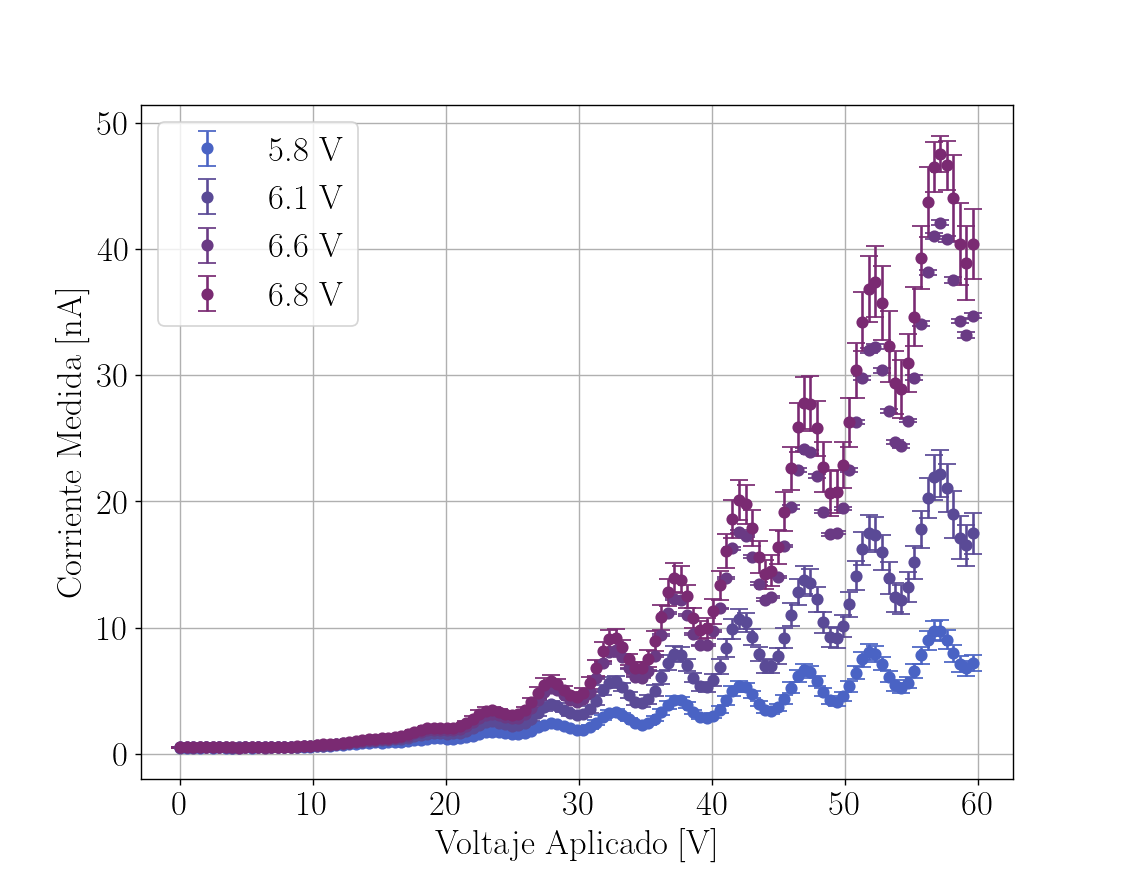

In [30]:
plt.figure(figsize = (9, 7))

N = 20
for i in range(0, len(UHData)):
    plt.errorbar(UHData[i][0][::N], UHData[i][1][::N], yerr = UHData[i][2][::N], color = Colors[i], label = UHNames[i], capsize = 5, fmt = "o")

plt.ylabel("Corriente Medida [nA]")
plt.xlabel("Voltaje Aplicado [V]")   
plt.legend()
plt.grid(True)
# plt.savefig("UHData.pdf")

Se logra apreciar que, a mayores valores de $U_{H}$, mayor es la corriente medida. Una vez más, la explicación de este comportamiento se deja para el informe :3.

<IPython.core.display.Javascript object>


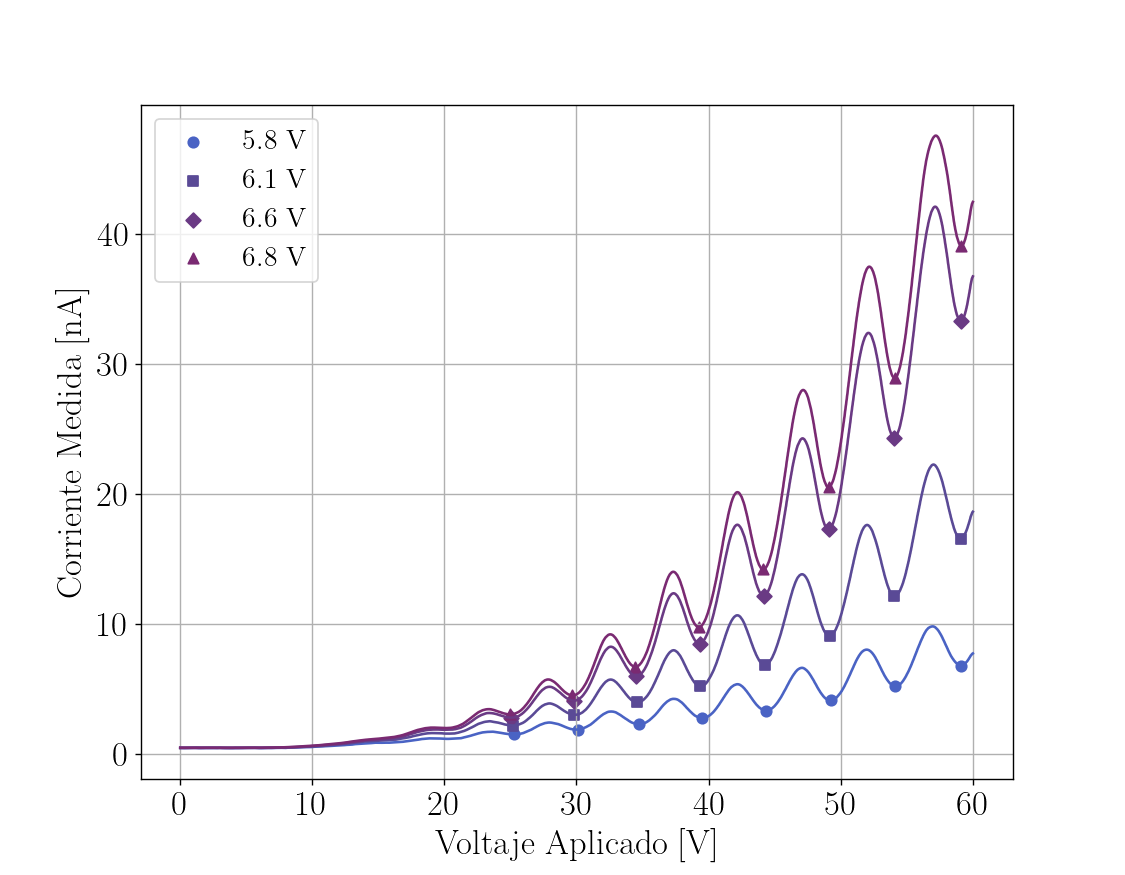

In [31]:
plt.figure(figsize = (9, 7))
Markers = ["o", "s", "D", "^", "v", "p"]
UHs = []

N = 1
for i in range(0, len(UHData)):
    UH_x = np.array([])
    UH_y = np.array([])
    
    plt.plot(UHData[i][0][::N], UHCurrents[i][::N], color = Colors[i])
    
    for j in range(0, len(UHMinimas[i][0])):
        if UHMinimas[i][0][j] > 21:
            if j == len(UHMinimas[i][0]) - 1:
                plt.scatter(UHMinimas[i][0][j], UHMinimas[i][1][j], marker = Markers[i], color = Colors[i], label = UHNames[i])
            else:
                plt.scatter(UHMinimas[i][0][j], UHMinimas[i][1][j], marker = Markers[i], color = Colors[i])
                
            UH_x = np.append(UH_x, UHMinimas[i][0][j]) 
            UH_y = np.append(UH_y, UHMinimas[i][1][j])
    
    UHs.append({UHNames[i]:(UH_x, UH_y)})
    
plt.ylabel("Corriente Medida [nA]")
plt.xlabel("Voltaje Aplicado [V]")   
plt.legend(prop={'size': 16})
plt.grid(True)
# plt.savefig("UHReg.pdf")

<IPython.core.display.Javascript object>


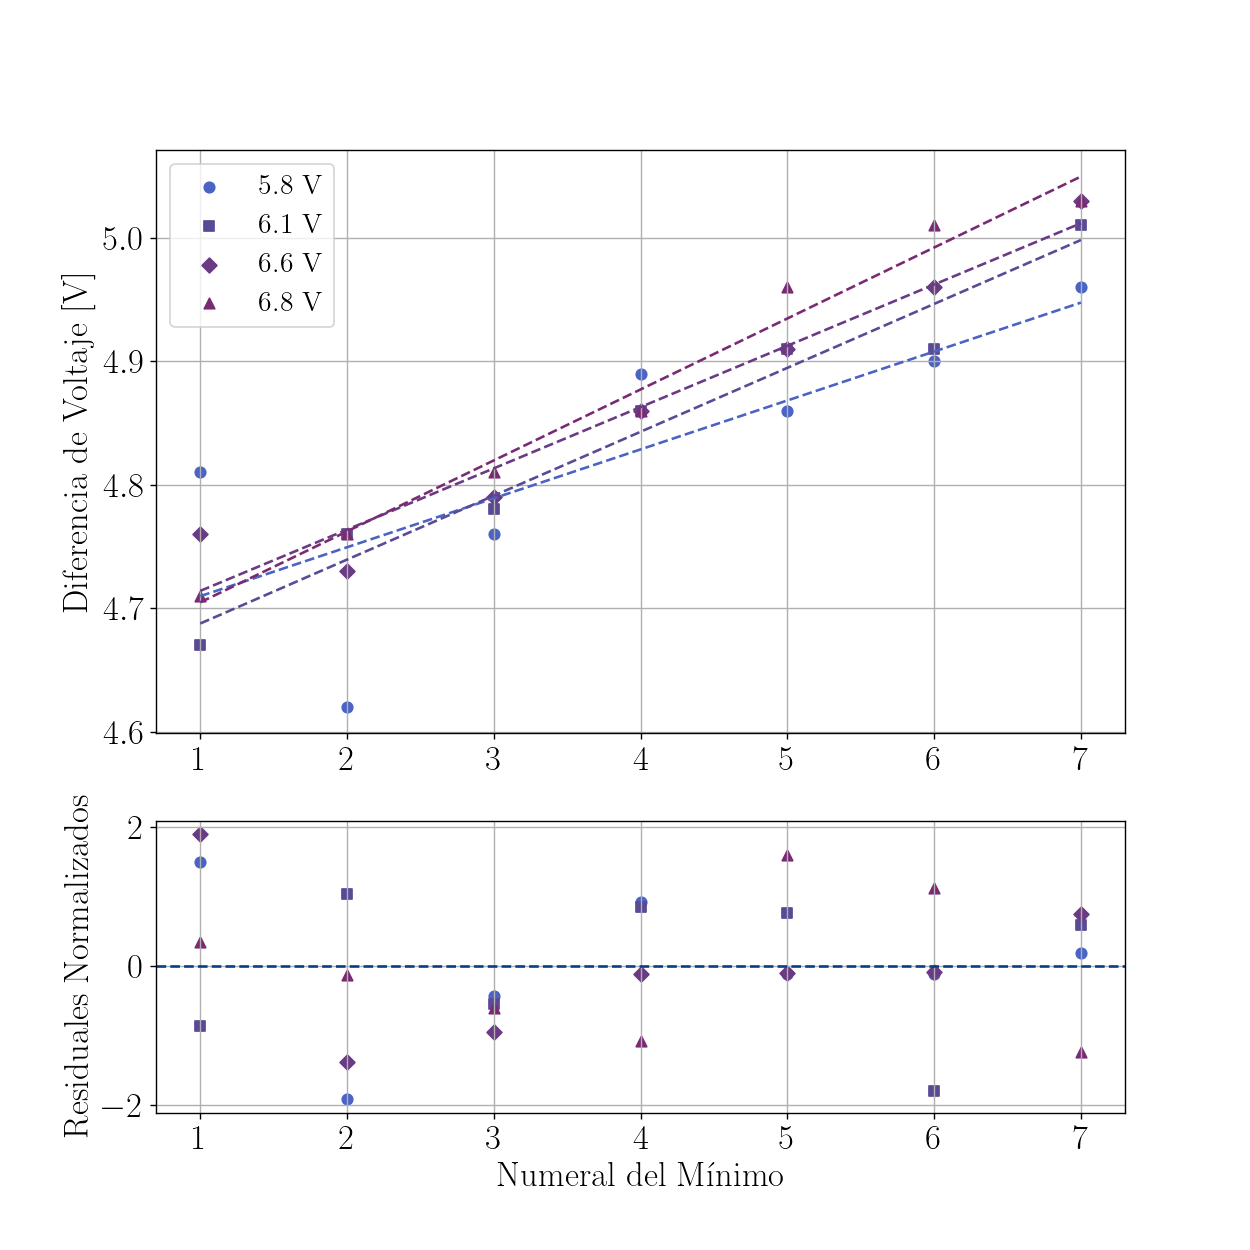

(4.69, 0.07) (0.05, 0.02) 0.2857142857142923
(4.66, 0.02) (0.067, 0.006) 0.49999999999998934
(4.69, 0.02) (0.064, 0.007) 1.000000000000023
(4.68, 0.02) (0.074, 0.005) 0.49999999999998934


In [33]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
Markers = ["o", "s", "D", "^", "v", "p"]

for i in range(0, len(UHs)):
    UHSet = UHs[i][UHNames[i]]
    UH_Num, UH_Delta = Separation(UHSet)
    UHX_, UHY_, UHRes_, UHEa, UHL = LinearRegression(UH_Num, UH_Delta)
    axis[0].scatter(UH_Num, UH_Delta, marker = Markers[i], color = Colors[i], label = UHNames[i])
    axis[0].plot(UHX_, UHY_, color = Colors[i], linestyle = "--")
    axis[1].scatter(UH_Num, UHRes_, marker = Markers[i], color = Colors[i])
    print(UHEa, UHL, np.abs(4.67 - UHEa[0])/UHEa[1])

axis[1].set_xlabel("Numeral del Mínimo")
axis[0].set_ylabel("Diferencia de Voltaje [V]")   
axis[1].set_ylabel("Residuales Normalizados") 
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[0].legend(prop = {'size': 16})
axis[0].grid(True)
axis[1].grid(True)
# plt.savefig("UHLine.pdf")